# **Dataset & Dataloader**
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity.

So PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. 

* `Dataset` 은 샘플과 정답(label)을 저장한다

* `DataLoader` 는 Dataset 을 샘플에 쉽게 접근할 수 iterable 객체로 감싼다

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass `torch.utils.data`.<br>`Dataset` and implement functions specific to the particular data. <br>They can be used to **prototype** and **benchmark** your model. 

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 🗃 loading a dataset

Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.


<h3> datasets Parameter

* `root` is the path where the train/test data is stored
* `train` specifies training or test dataset
* `download=True` downloads the data from the internet if it’s not available at `root`.
* `transform` and `target_transform` specify the feature and label transformations

In [3]:
# FashionMNIST train, test data download

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [8]:
# training_data size
len(training_data)

60000

# 1. Iterating and Visualizing the Dataset

`Dataset` 에 리스트(list)처럼 직접 접근(index)할 수 있습니다: `training_data[index]` <br>`matplotlib` 을 사용하여 학습 데이터의 일부를 시각화해봅시다.

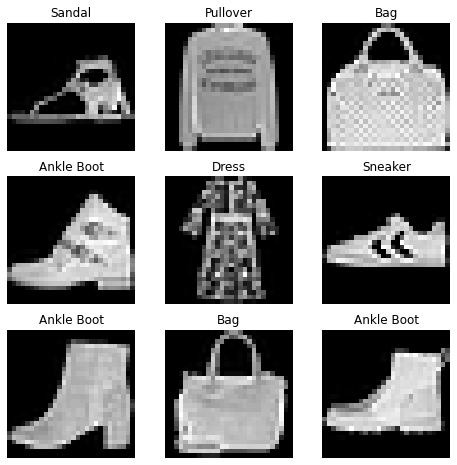

In [9]:
## FasionMNIST label to Name dict
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

## FashionMNIST 시각화
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):

    # training_data 에서 random으로 index 값 꺼내기
    sample_idx = torch.randint(len(training_data), size=(1,)).item()

    # sample_idx로 datasets에서 indexing -> img data, label을 동시에
    img, label = training_data[sample_idx]

    # figure 설정
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # img squeeze, imshow
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 2. Creating a Custom Dataset for your files

🌟 **`A custom Dataset`** class ***must implement*** three functions: `__init__`, `__len__`, and `__getitem__`. 
<br><br>
Take a look at this implementation; <br>the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

In [10]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, name=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # img_path 만 indexing
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # read_image
        image = read_image(img_path)

        # image label 값 받아오기
        label = self.img_labels.iloc[idx, 1]

        # transform (image, label)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## `__init__`
__init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다. 
<br>여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두가지 transform 을 초기화합니다.



labels.csv 파일은 다음과 같습니다:

tshirt1.jpg, 0<br>
tshirt2.jpg, 0<br>
......<br>
ankleboot999.jpg, 9<br>

In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

## `__len__`

In [ ]:
def __len__(self):
    return len(self.img_labels)

## `__getitem__`
__getitem__ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다. <br>
* 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별
* read_image 를 사용하여 이미지를 텐서로 변환
* self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져옴
* (해당하는 경우) 변형(transform) 함수들을 호출
* 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환

In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

    # image 저장
    image = read_image(img_path)
    # label 저장
    label = self.img_labels.iloc[idx, 1]

    # transform
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    sample = {"image": image, "label": label}
    return sample

# 3. Preparing your data for training with DataLoaders

* Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 
* 모델을 학습 시, 
  * 일반적으로 샘플들을 “**미니배치(minibatch)**”로 전달
  * 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit) 방지
  * Python의 multiprocessing 을 사용하여 데이터 검색 속도 향상

`DataLoader`는 이러한 복잡한 과정들을 요약한 iterable 객체 API 이다.

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

`DataLoader` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 

아래의 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환합니다. 
<br><br>

`shuffle=True` 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다. 

(데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) 를 살펴보세요.)

In [13]:
# DataLoader 첫 번째 iter 저장
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


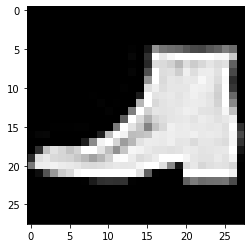

Label: 9


In [14]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

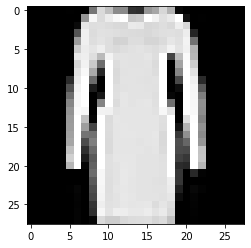

Label Name: Dress


In [22]:
# 2번 째 iter image visualizing
plt.imshow(train_features[1].squeeze(), cmap="gray")
plt.show()
label = train_labels[1]
print(f"Label Name: {labels_map[label.item()]}")

In [23]:
# DataLoader 2번 째 iter 저장
train_features2, train_labels2 = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


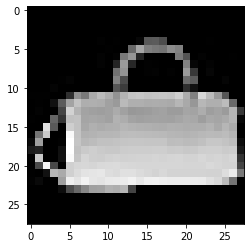

Label: Bag


In [24]:
# 2 번째 iter index0 image visualizing
img = train_features2[0].squeeze()
label = train_labels2[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")